# An example of applying mSSA to the coefficients you created using pyEXP

This example assumes that you have run the `Part1-Coefficients` notebook to create the coefficients.

We begin by importing `pyEXP` and friends and setting the working directory.

In [14]:
import os
import yaml
import pyEXP
import numpy as np
import matplotlib.pyplot as plt

# In this test, I assume that you have already explored and run Part1-Coefficients. This notebook does some additional 
# analysis and plotting
#
os.chdir('../Data')

## Create the basis
This step is the same as in the previous notebook.  We are going to use the basis for field evaluation so we need the basis.

In [15]:
# Get the basis config
#
yaml_config = ""
with open('basis.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    yaml_config = yaml.dump(config)

# Construct the basis instance
#
basis = pyEXP.basis.Basis.factory(yaml_config)

---- SLGridSph::ReadH5Cache: successfully read basis cache <sphereSL.model>
Spherical::orthoTest: worst=0.00016446


So far, this is the same as in `Part1` . . . now:

## Reading the halo coefficients
We created the halo coefficients in the last notebook and stashed them in the EXP HDF5 format.  Now, we'll read them back.

In [16]:
# Reread the coefs from the file
#
coefs = pyEXP.coefs.Coefs.factory('test_coefs')

print("Got coefs for name=", coefs.getName())

Got coefs for name= dark halo


## Visualizing the fields
We made a few test grids in Part 1 of the notebook.  This time, we'll make surface renderings:

We now have the following [time field] pairs
----------------------------------------
  0.0100  azi force
  0.0100  dens
  0.0100  dens m=0
  0.0100  dens m>0
  0.0100  mer force
  0.0100  potl
  0.0100  potl m=0
  0.0100  potl m>0
  0.0100  rad force
----------------------------------------
  0.0200  azi force
  0.0200  dens
  0.0200  dens m=0
  0.0200  dens m>0
  0.0200  mer force
  0.0200  potl
  0.0200  potl m=0
  0.0200  potl m>0
  0.0200  rad force
----------------------------------------
  0.0300  azi force
  0.0300  dens
  0.0300  dens m=0
  0.0300  dens m>0
  0.0300  mer force
  0.0300  potl
  0.0300  potl m=0
  0.0300  potl m>0
  0.0300  rad force
----------------------------------------
  0.0400  azi force
  0.0400  dens
  0.0400  dens m=0
  0.0400  dens m>0
  0.0400  mer force
  0.0400  potl
  0.0400  potl m=0
  0.0400  potl m>0
  0.0400  rad force
----------------------------------------
  0.0500  azi force
  0.0500  dens
  0.0500  dens m=0
  0.0500  dens m>0
  0.0500  mer

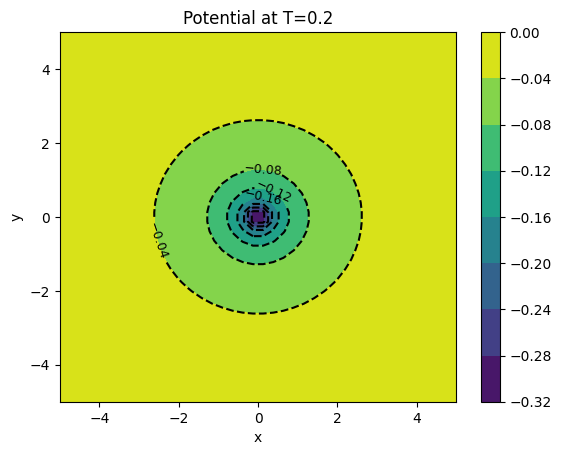

Text(0.5, 1.0, 'Radial force at T=0.2')

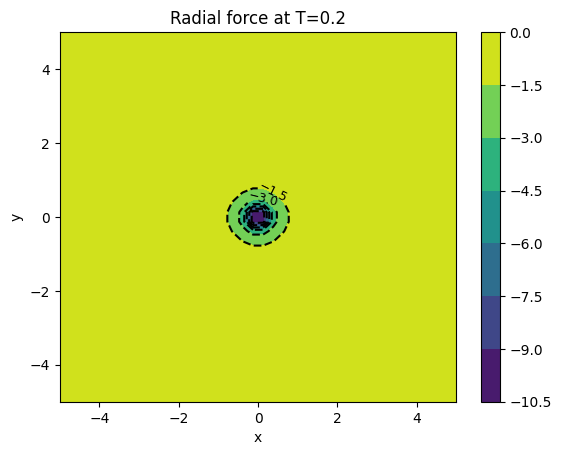

In [17]:
# Now try some slices for rendering
#
times = coefs.Times()
pmin  = [-5.0, -5.0, 0.0]
pmax  = [ 5.0,  5.0, 0.0]
grid  = [  40,   40,   0]

fields = pyEXP.field.FieldGenerator(times, pmin, pmax, grid)

surfaces = fields.slices(basis, coefs)

print("We now have the following [time field] pairs")
final = 0.0
for v in surfaces:
    print('-'*40)
    for u in surfaces[v]:
        print("{:8.4f}  {}".format(v, u))
        final = v

# Print the potential image at the final time (I think there is a
# fencepost issue in this grid, no matter).
x = np.linspace(pmin[0], pmax[0], grid[0])
y = np.linspace(pmin[1], pmax[1], grid[1])
xv, yv = np.meshgrid(x, y)

# Visualize the final time slice in grid.  Obviously, we could use any 
# field we want.  Here is potential and radial force.

cont1 = plt.contour(xv, yv, surfaces[final]['potl'].transpose(), colors='k')
plt.clabel(cont1, fontsize=9, inline=True)
cont2 = plt.contourf(xv, yv, surfaces[final]['potl'].transpose())
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Potential at T={}'.format(final))
plt.show()

cont1 = plt.contour(xv, yv, surfaces[final]['rad force'].transpose(), colors='k')
plt.clabel(cont1, fontsize=9, inline=True)
cont2 = plt.contourf(xv, yv, surfaces[final]['rad force'].transpose())
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Radial force at T={}'.format(final))

## Using MSSA
Generate the initial MSSA analyis and plot the run of eigenvalues

Keys= [[1, 0, 0], [1, 0, 1], [1, 0, 2], [1, 0, 3], [1, 0, 4], [1, 0, 5], [1, 0, 6], [1, 0, 7], [1, 0, 8], [1, 0, 9], [1, 1, 0], [1, 1, 1], [1, 1, 2], [1, 1, 3], [1, 1, 4], [1, 1, 5], [1, 1, 6], [1, 1, 7], [1, 1, 8], [1, 1, 9]]
Window=10 PC number=10
Trajectory is true
shape U = 300 x 11
shape Y = 11 x 300


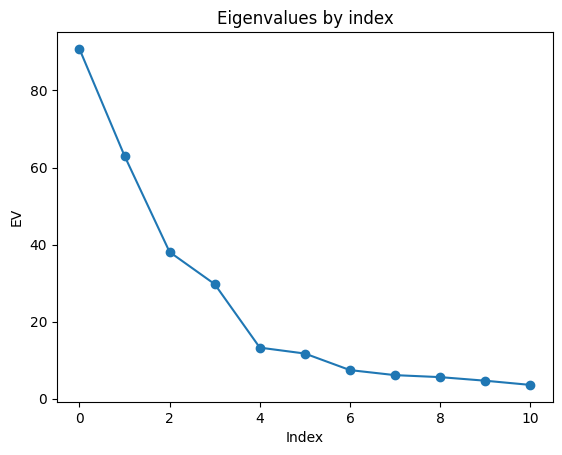

In [18]:
# Make a subkey sequence
#
keylst = coefs.makeKeys([1])
print("Keys=", keylst)

name = 'dark halo'
config = {name: (coefs, keylst, [])}

# This is the window length.  The largest meaningful length is half
# the size of the time series.  We'll choose that here but it *is*
# interesting to retry these analyses with different window lengths.

window = int(len(coefs.Times())/2)
npc = 10

print("Window={} PC number={}".format(window, npc))

ssa = pyEXP.mssa.expMSSA(config, window, npc)

ev = ssa.eigenvalues()

plt.plot(ev, 'o-')
plt.xlabel("Index")
plt.ylabel("EV")
plt.title("Eigenvalues by index")
plt.show()

### Next plot the principle components.

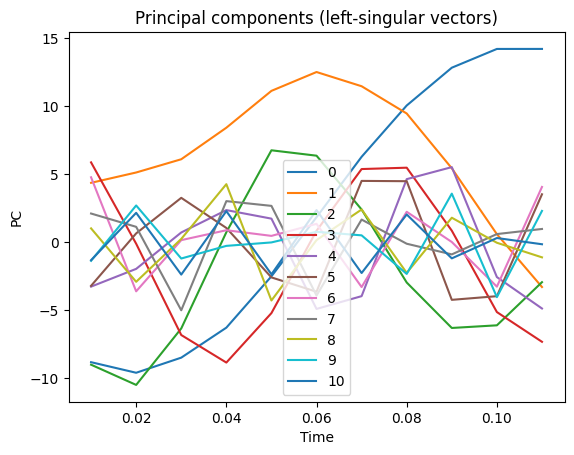

In [19]:
times = coefs.Times();
pc    = ssa.getPC();

rows, cols = pc.shape

for i in range(cols):
    plt.plot(times[0:rows], pc[:,i], '-', label="{:d}".format(i))

plt.xlabel('Time')
plt.ylabel('PC')
plt.legend()
plt.title("Principal components (left-singular vectors)")
plt.show()

### Now try a reconstruction

In [20]:
ssa.reconstruct([0, 1, 2, 3])

coefs.zerodata() # <---replace with reconstructed
newdata = ssa.getReconstructed()
print('newdata is a', type(newdata))

newdata is a <class 'dict'>


### Compute the k-means analysis
Each channel is the real or imaginary part (designated cosine [c] or sine [s]).  These could be combined and this will be done in a later update.   The k-means analysis illustrates the clear patterns in the PCs seen in the plots above: the individual features occur in pairs, dominated by the first two pairs as seen in the eigenvalue plot.

In [21]:
# Print k-means groups
#
ssa.kmeans()

----------------------------------------
---- K-means group analysis
---- numT=20 numW=10
----------------------------------------
------------------------------------------------------------
 *** n=(1,0,0,c)_0
------------------------------------------------------------
     0           0
     1           0
     2           1
     3           1
     4           0
     5           0
     6           0
     7           0
     8           0
     9           0
------------------------------------------------------------
 *** n=(1,0,1,c)_0
------------------------------------------------------------
     0           0
     1           0
     2           1
     3           1
     4           0
     5           0
     6           0
     7           0
     8           0
     9           0
------------------------------------------------------------
 *** n=(1,0,2,c)_0
------------------------------------------------------------
     0           0
     1           0
     2           1
     3   

### Finally plot the w-correlation matrix
This is the sum of the w-correlation matrices for all channels.

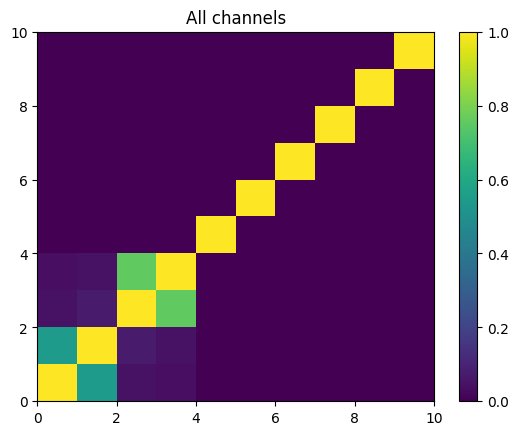

In [22]:
mat = ssa.wCorrAll()
x = plt.pcolormesh(mat)
plt.title("All channels")
plt.colorbar(x)
plt.show()

One can also look at individual channels.

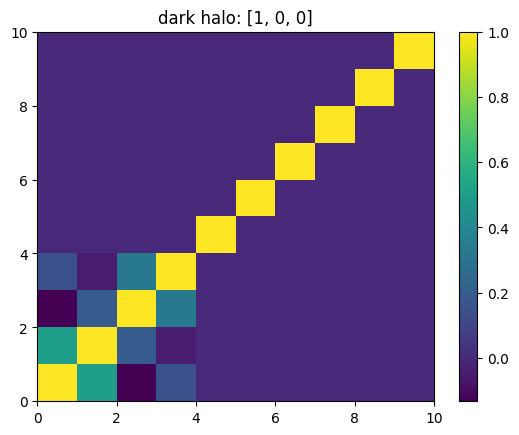

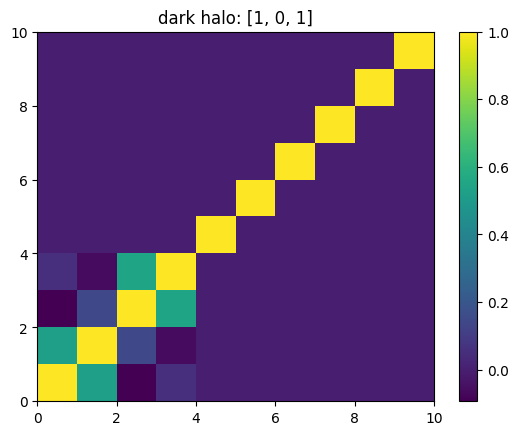

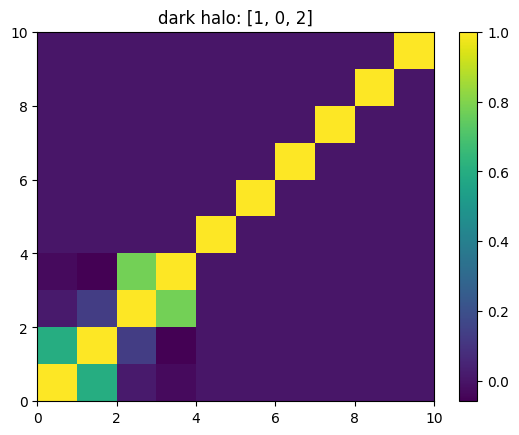

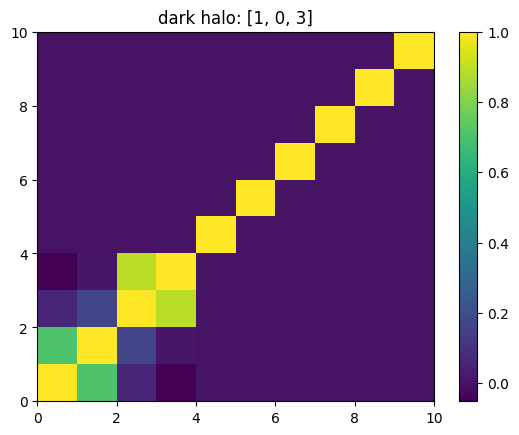

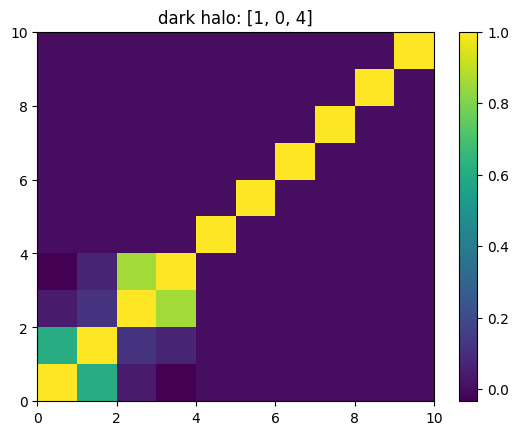

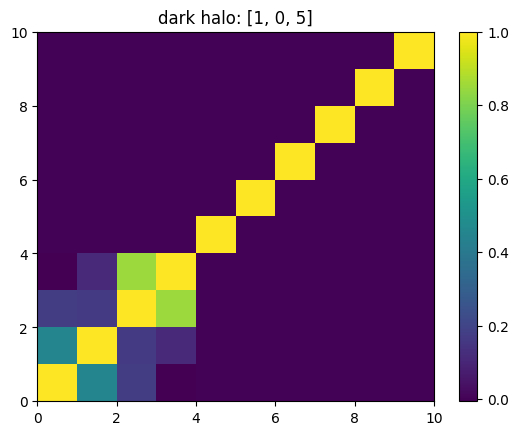

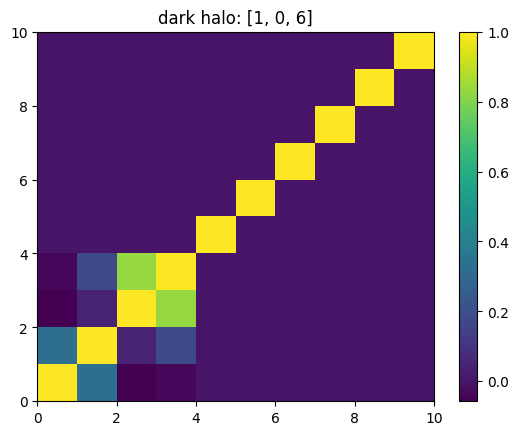

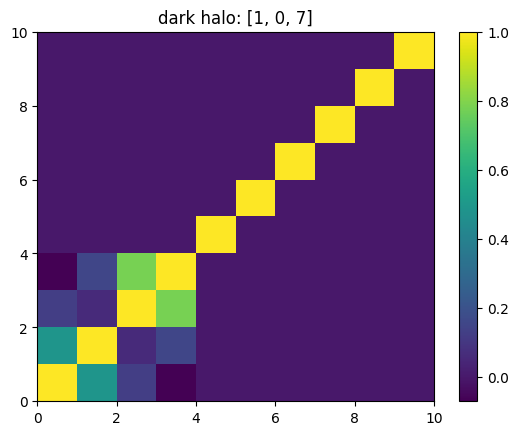

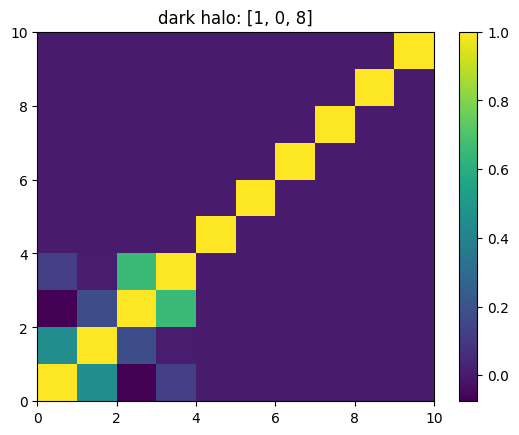

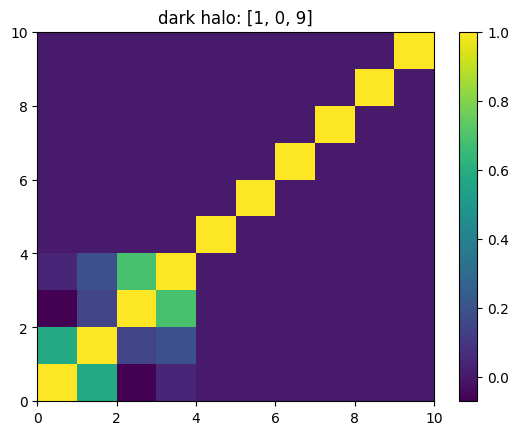

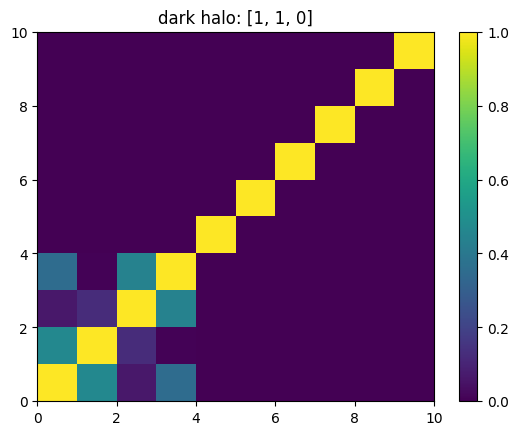

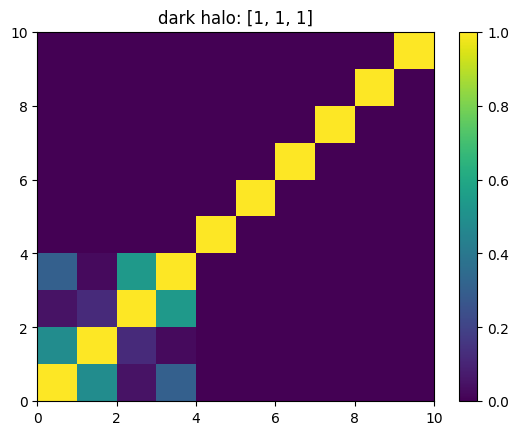

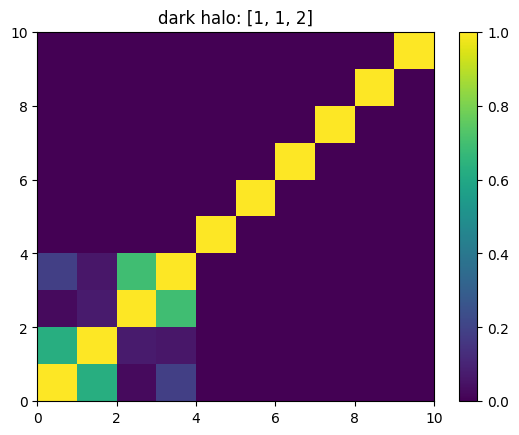

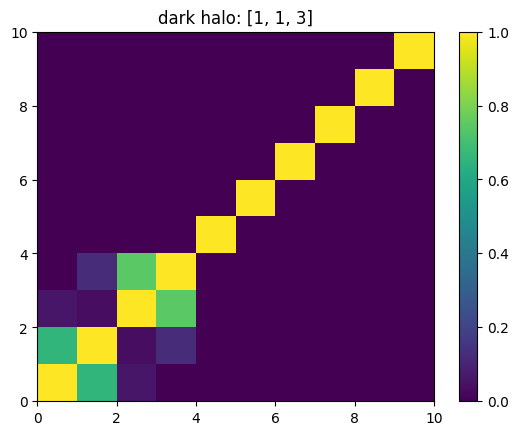

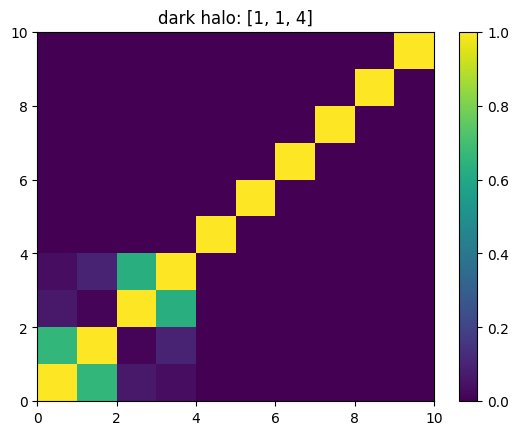

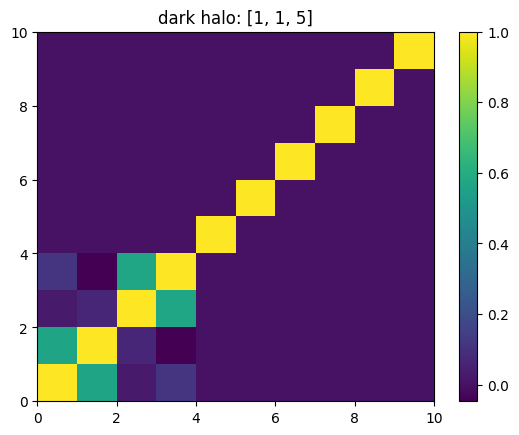

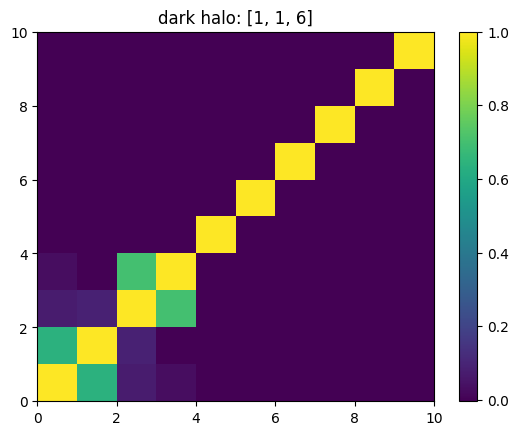

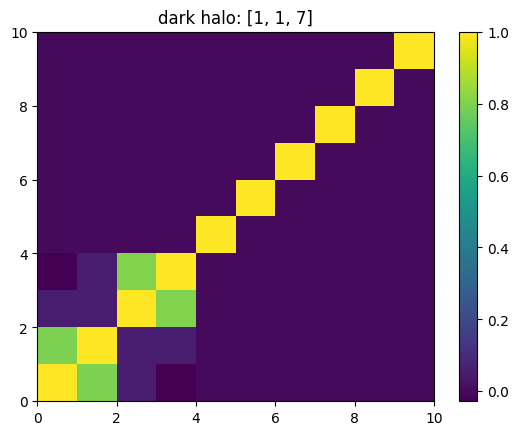

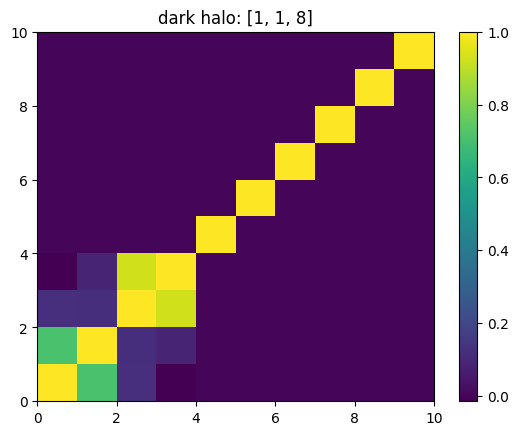

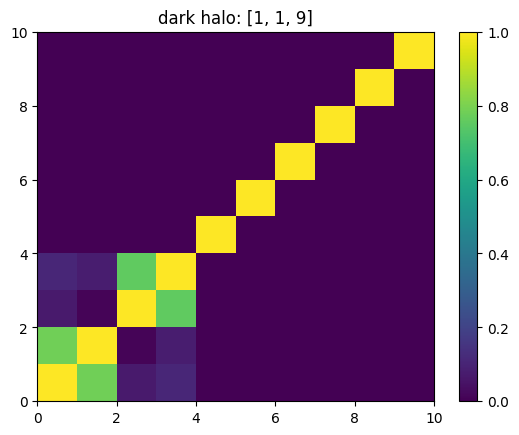

In [23]:
# Get and view the w-correlation matrices
# for each key individually
#
for k in keylst:
    mat = ssa.wCorr(name, k)
    # Plot it
    x = plt.pcolormesh(mat)
    plt.title('{}: {}'.format(name,k))
    plt.colorbar(x)
    plt.show()